# Solve 2D Navier-Stokes Equations with PINN

The Navier-Stokes (NS) equations describe the motion of fluid substances such as liquids and gases. These equations are a set of nonlinear partial differential equations derived from Newton's second law of motion, accounting for viscosity (internal friction) in fluids. They consist of a continuity equation (conservation of mass) and a momentum equation (conservation of momentum).

In mathematical form, the NS equations for an incompressible fluid are:

**Continuity Equation:**
$$
\nabla\cdot\mathbf{u}=0
$$

**Momentum Equation:**
$$
\frac{\partial\mathbf{u}}{\partial t}+(\mathbf{u}\cdot\nabla\mathbf{u})=-\frac{1}{\rho}\nabla p+\nu\nabla^2\mathbf{u}+\mathbf{f}
$$

where:
- $\mathbf{u}$ is the fluid velocity vector,
- $t$ is time,
- $p$ is the pressure,
- $\rho$ is the (mass) density,
- $\nu$ is the kinematic viscosity,
- $\mathbf{f}$ represents external forces (e.g., gravity).

## Complexity Finding Analytical Solution on NS Equations
- **Nonlinearity**: The term $(\mathbf{u}\cdot\nabla\mathbf{u})$ introduces significant nonlinearity. This makes the equations difficult to solve analytically because small changes in the initial conditions can lead to vastly different outcomes, a characteristic of chaotic systems.

- **Complex Boundary Conditions**: Fluids often interact with complex boundaries (e.g., the surface of a wing, the walls of a pipe), requiring intricate boundary conditions that complicate the solution process.

- **Three-Dimensional Nature**: Fluids typically move in three dimensions, increasing the complexity of the equations and making them harder to solve analytically.

- **Turbulence**: At high velocities or with large Reynolds numbers, fluid flow can become turbulent, exhibiting chaotic behavior that is difficult to predict and model analytically.

Because of these complexities, analytical solutions are rare and usually limited to simple, idealized cases. Most practical problems require numerical methods and computational fluid dynamics (CFD) for approximate solutions. Here we demonstrate the possibility of implementing PINN for end-to-end solution model

## Defining the 2D Incompressible NS Equations

The 2D incompressible NS equations are given by:

1.  **Momentum Equations**
    $$
    \left\{\begin{matrix}
    \frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y}=-\frac{1}{\rho}\frac{\partial p}{\partial x} + \nu\left(\frac{\partial^2u}{\partial x^2}+\frac{\partial^2u}{\partial y^2}\right)\\ 
    \frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y}=-\frac{1}{\rho}\frac{\partial p}{\partial y} + \nu\left(\frac{\partial^2v}{\partial x^2}+\frac{\partial^2v}{\partial y^2}\right)
    \end{matrix}\right.
    $$
2.  **Continuity Eqation**
    $$
    \frac{\partial u}{\partial x}+\frac{\partial v}{\partial y}=0
    $$


where $u$ and $v$ are the velocity components in the $x$ and $y$ directions respectively, $p$ is pressure and $\nu$ is the kinematic viscosity.

## Library Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

2024-05-22 18:24:33.185741: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 18:24:33.222199: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 18:24:33.830189: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Generate Training Data
We need both the initial/boundary conditions data and collocation points for the PDE.

For demonstration here we adopt boundary condition of open-top box with accelerating x motion at the top. Thus we define a grid where the top boundary has a constant horizontal velocity while all other boundary are non-slipper (speed = 0). The synthetic data will be in a unit square of domain $[0,1]\times[0,1]$ with the following conditions

- At $y=1$ (top boundary): $u=at$ (accelerating x motion), $v=0$ (no y motion);
- At $y=0$ (bottom boundary): $u=v=0$ (non-slippery wall);
- At $x=0$ and $x=1$ (side boundaries): $u=v=0$ (non-slippery wall);

We will generate a grid of points in this domain and assign the boundary conditions accordingly.

In [2]:
def generate_data(grid_res=100,a=2):
    X = []
    Y = []
    T = []
    u = []
    v = []
    
    # top boundary condition
    x_ = np.linspace(0,1,num=grid_res)
    y_ = np.array(1)
    t_ = np.linspace(0,1,10) # 10 time points only
    X_, Y_, T_ = np.meshgrid(x_,y_,t_)
    v_ = np.zeros_like(X_)
    u_ = a*T_

    X.append(X_.flatten())
    Y.append(Y_.flatten())
    T.append(T_.flatten())
    u.append(u_.flatten())
    v.append(v_.flatten())

    # bottom boundary condition
    x_ = np.linspace(0,1,num=grid_res)
    y_ = np.array(0)
    t_ = np.linspace(0,1,10) # 10 time points only
    X_, Y_, T_ = np.meshgrid(x_,y_,t_)
    v_ = np.zeros_like(X_)
    u_ = np.zeros_like(X_)
    X.append(X_.flatten())
    Y.append(Y_.flatten())
    T.append(T_.flatten())
    u.append(u_.flatten())
    v.append(v_.flatten())


    # left boundary condition
    x_ = np.array(0)
    y_ = np.linspace(0,1,num=grid_res)
    t_ = np.linspace(0,1,10) # 10 time points only
    X_, Y_, T_ = np.meshgrid(x_,y_,t_)
    v_ = np.zeros_like(X_)
    u_ = np.zeros_like(X_)
    X.append(X_.flatten())
    Y.append(Y_.flatten())
    T.append(T_.flatten())
    u.append(u_.flatten())
    v.append(v_.flatten())

    # right boundary condition
    x_ = np.array(1)
    y_ = np.linspace(0,1,num=grid_res)
    t_ = np.linspace(0,1,10) # 10 time points only
    X_, Y_, T_ = np.meshgrid(x_,y_,t_)
    v_ = np.zeros_like(X_)
    u_ = np.zeros_like(X_)

    X.append(X_.flatten())
    Y.append(Y_.flatten())
    T.append(T_.flatten())
    u.append(u_.flatten())
    v.append(v_.flatten())

    x_train = np.hstack((np.hstack(X)[:, None],np.hstack(Y)[:, None], np.hstack(T)[:, None]))
    u_train = np.hstack((np.hstack(u).flatten()[:,None],np.hstack(v).flatten()[:,None]))

    return x_train, u_train
x_train, u_train = generate_data()

x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
u_train = tf.convert_to_tensor(u_train, dtype=tf.float32)

2024-05-22 18:24:35.640297: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6536 MB memory:  -> device: 0, name: Quadro RTX 4000, pci bus id: 0000:65:00.0, compute capability: 7.5


/home/jackyko/mambaforge/envs/pyhisto/lib/python3.10/site-packages/matplotlib/quiver.py:649: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/jackyko/mambaforge/envs/pyhisto/lib/python3.10/site-packages/matplotlib/quiver.py:649: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


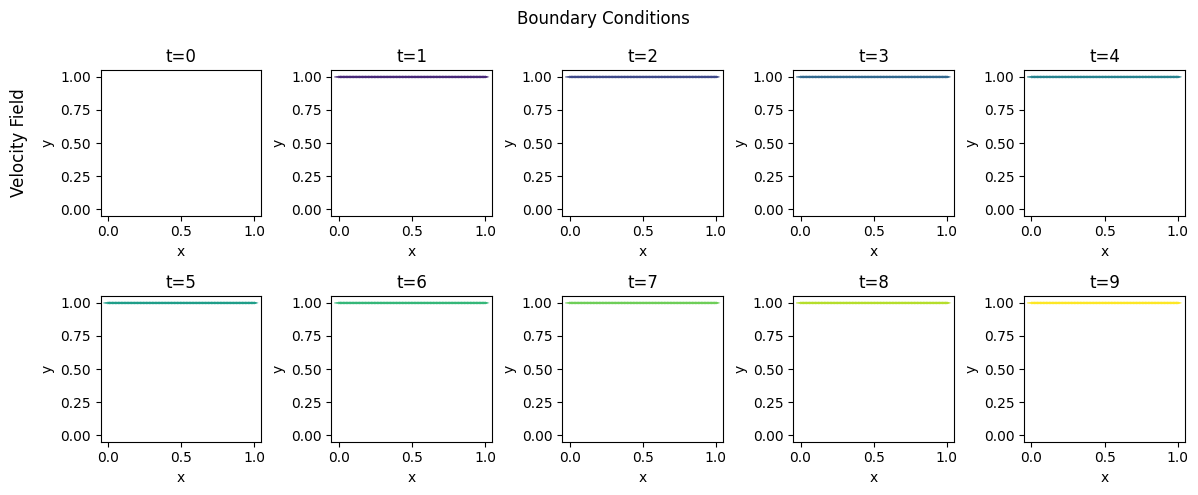

In [3]:
# Plotting
PLOTS = 10
fig, axs = plt.subplots(2,5, figsize=(12, 5))
axs = axs.ravel()

fig.suptitle("Boundary Conditions")
axs[0].annotate("Velocity Field", xy=(0, 0.5), xytext=(-axs[0].yaxis.labelpad - 5, 0),
                xycoords=axs[0].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center',rotation=90)

EDGES=4

for t in range(PLOTS):
    # velocity field boundary conditions
    axs[t].set_xlabel("x")
    axs[t].set_ylabel("y")

    for i in range(EDGES):
        x = x_train[:,0].numpy().reshape((EDGES,100,1,10))[i,:,:,t]
        y = x_train[:,1].numpy().reshape((EDGES,100,1,10))[i,:,:,t]
        u = u_train[:,0,].numpy().reshape((EDGES,100,10))[i,:,t]
        v = u_train[:,1,].numpy().reshape((EDGES,100,10))[i,:,t]

        q = axs[t].quiver(x,y,u,v,np.hypot(u,v),pivot="middle")
        q.set_clim(0,2)

    axs[t].set_title('t={}'.format(t))
    axs[t].set_xlim((-0.05,1.05))
    axs[t].set_ylim((-0.05,1.05))

plt.tight_layout()


## Neural Network Setup
Here we follow the PINN configuration by C. Amalinadhi et al.:
![alt text](../figs/pinn_ns_psi.ppm "PINN Navier-Stokes")

- Input: $(x,y,t)$
- Output: $(\psi(x,y),p)$, that $\psi(x,y)$ is the scalar potential function (stream function) that given by $u=\frac{\partial\psi_z}{\partial y}$, $v=-\frac{\partial\psi_z}{\partial x}$.

### Helmholtz Decomposition Theorem
It is worth mention that the PINN is not directly mapping velocity outcome, instead the scalar potential term is set to be the network output for better training stability. Underneath the idea is link back to the **Helmholtz decomposition theorem**.

For every vector field $\vec v(\vec r)$, it can be decomposed into the sum of gradient of *scalar potential* $\phi(\vec r)$ and *vector potential* $\vec A(\vec r)$:
$$
\vec v(\vec r) = -\nabla\phi(\vec r)+\nabla\times\vec A(\vec r)
$$

![alt text](../figs/helmholtz_decomp.png "Helmholtz Decomposition")

Note that this decomposition always has a solution but not necessarily unique. Mathematically this decomposition always give an irrotational (curl free) and a solenoid (divergence-free) vector field such that:
$$
\left\{\begin{matrix}
\vec F(\vec r)=\vec G(\vec r)+\vec R(\vec r )\\
\vec G(\vec r)=-\nabla\phi(\vec r)\\
\nabla\cdot \vec R(\vec r)=0
\end{matrix}
\right.
$$

The scalar potential term $\vec G$ is curl free for $\nabla\times(\nabla \phi)= 0$ and vector potential term $\vec R$ is divergence free that $\nabla\cdot(\nabla\times\vec A)=0$.

Further vector analysis yields
$$
\nabla^2\phi=\nabla\cdot\nabla\psi=0\\
\nabla\times(\nabla\times\vec A)=\nabla\times\vec v =\omega
$$

### Forward and Inverse Problem
PINN can be used to learn the vector potential $\vec A=(\psi_x,\psi_y,\psi_z)$ such that
$$
\vec v_{\text{PINN}} = \nabla\times\vec A_{\text{PINN}} = 
\left(\begin{matrix}
\frac{\partial \psi_z}{\partial y}-\frac{\partial \psi_y}{\partial z}\\
\frac{\partial \psi_x}{\partial z}-\frac{\partial \psi_z}{\partial x}\\
\frac{\partial \psi_y}{\partial x}-\frac{\partial \psi_x}{\partial y}
\end{matrix}
\right)
$$

For 2D cases, $u=\frac{\partial\psi}{\partial y}$, $v=-\frac{\partial\psi}{\partial x}$

In [4]:
def create_model():
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(3,))) # (x,y,t)
    model.add(layers.Dense(20, activation='tanh'))
    model.add(layers.Dense(20, activation='tanh'))
    model.add(layers.Dense(20, activation='tanh'))
    model.add(layers.Dense(2, activation=None))  # Output psi, p
    return model

model = create_model()

/home/jackyko/mambaforge/envs/pyhisto/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Plug the data input and output to the PINN model

## Defining Physics Informed Loss Function

The loss function includes both the data loss and the PDE residual loss.
$$
L_\text{PINN} = L_\text{2,Data} + L_\text{2,Residual}
$$

### PDE Residual Loss
Mean squared error of the PDE residual.
Using automatic differentiation to compute the required derivatives for the momentum losses:
$$
L_{\text{residual}}=\left\{\begin{matrix}
f(x,y,t)= \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y}+\frac{1}{\rho}\frac{\partial p}{\partial x}-\nu\left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}\right) \\
g(x,y,t) = \frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y}+\frac{1}{\rho}\frac{\partial p}{\partial y}-\nu\left(\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2}\right)
\end{matrix}\right.
$$

$$
L_\text{PINN} = \frac{1}{N}\sum_{i=1}^N \left(\left|u_{\text{{PINN},i}}-u_{\text{BC,i}}\right|^2 + \left|v_{\text{{PINN},i}}-v_{\text{BC,i}}\right|^2\right)
+ \frac{1}{N}\sum_{i=1}^N\left(\left|f_i\right|^2 + \left|g_i\right|^2\right)
$$

In [5]:
def ns_eq_residual(u, v, p, x, y, t, rho, nu):
    u_x = tf.gradients(u, x)[0]
    u_y = tf.gradients(u, y)[0]
    u_t = tf.gradients(u, t)[0]
    v_x = tf.gradients(v, x)[0]
    v_y = tf.gradients(v, y)[0]
    v_t = tf.gradients(v, t)[0]
    p_x = tf.gradients(p, x)[0]
    p_y = tf.gradients(p, y)[0]

    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    v_xx = tf.gradients(v_x, x)[0]
    v_yy = tf.gradients(v_y, y)[0]

    momentum_u = u_t + u * u_x + v * u_y + 1/rho*p_x - nu * (u_xx + u_yy)
    momentum_v = v_t + u * v_x + v * v_y + 1/rho*p_y - nu * (v_xx + v_yy)
    continuity = u_x + v_y

    return momentum_u, momentum_v, continuity

### Reynold Number
In fluid dynamics, the Reynolds number (Re) is a dimensionless quantity that helps predict fluid flow patterns in different situations by measuring the ratio between inertial and viscous forces. The Reynold number is defined as
$$
\text{Re}=\frac{uL}{\nu}=\frac{\rho uL}{\mu}
$$

where
- $\rho$ is the density of the fluid (SI units: $kg/m^3$)
- $u$ is the flow speed ($m/s$)
- $L$ is a characteristic length ($m$)
- $\mu$ is the dynamic viscosity of the fluid ($Pa·s$ or $N·s/m^2$ or $kg/(m·s)$)
- $\nu$ is the kinematic viscosity of the fluid ($m^2/s$).

In [6]:
# density
rho = 1
# viscosity
nu = 0.01
# characteristic length
L = 1
# flow speed
u = 1

Re = u*L/nu
print("Reynold number: {:.2f}".format(Re))

Reynold number: 100.00


### PINN Loss


In [7]:
def physics_informed_loss(model, x, y, t, u_true, v_true, rho=1, nu=0.01, lambda_1=1, lambda_2=1):
    psi_p_pred = model(tf.concat([x, y, t], axis=1))
    u_pred = tf.gradients(psi_p_pred[:,0], y)[0]
    v_pred = -tf.gradients(psi_p_pred[:,0], x)[0]
    p_pred = psi_p_pred[:1]

    residual = ns_eq_residual(u_pred, v_pred, p_pred, x, y, t, rho=rho,nu=nu)
    data_loss = tf.reduce_mean(tf.square(u_pred - u_true)+tf.square(v_pred - v_true))
    pde_loss = tf.reduce_mean(tf.square(residual))
    return lambda_1*data_loss + lambda_2*pde_loss

## Training

Train the neural network to minimize the combined loss function using gradient descent.

In [8]:
optimizer = Adam(learning_rate=1e-3)

In [9]:
@tf.function
def train_step(x, y, t, u_true, v_true):
    with tf.GradientTape() as tape:
        loss = physics_informed_loss(model, x, y, t, u_true, v_true, lambda_1=1, lambda_2=1)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [10]:
epochs = 700
loss_values = []
for epoch in range(epochs):
    loss_value = train_step(x_train[:, 0:1], x_train[:, 1:2], x_train[:, 2:3], u_train[:,0:1], u_train[:,1:2])
    loss_values.append(loss_value)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy()}")

/home/jackyko/mambaforge/envs/pyhisto/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 0, Loss: 0.41083407402038574
Epoch 100, Loss: 0.19178545475006104
Epoch 200, Loss: 0.14453119039535522
Epoch 300, Loss: 0.05422274395823479
Epoch 400, Loss: 0.031589724123477936
Epoch 500, Loss: 0.028961997479200363
Epoch 600, Loss: 0.023865096271038055


(0.0, 733.95)

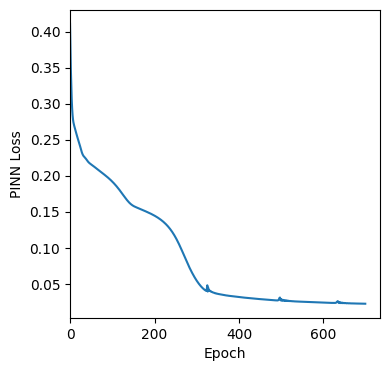

In [11]:
fig, axs = plt.subplots(1,1,figsize=(4,4))
axs.plot(np.arange(epochs),loss_values)
axs.set_xlabel("Epoch")
axs.set_ylabel("PINN Loss")
axs.set_xlim(left=0)

## Plot PINN Solutions

In [12]:
# Generate testing data
grid_res = 100
X = []
Y = []
T = []
u = []
v = []

# mesh grid
x_ = np.linspace(0,1,num=grid_res)
y_ = np.linspace(0,1,num=grid_res)
t_ = np.linspace(0,1,10) # 10 time points only
X_, Y_, T_ = np.meshgrid(x_,y_,t_)

x_test = np.hstack((X_.flatten()[:, None],Y_.flatten()[:, None], T_.flatten()[:, None]))

In [13]:
# PINN predictions
psi_p_pinn = model(x_test,)

In [14]:
psi_p_pinn = psi_p_pinn.numpy().reshape((100,100,10,2))

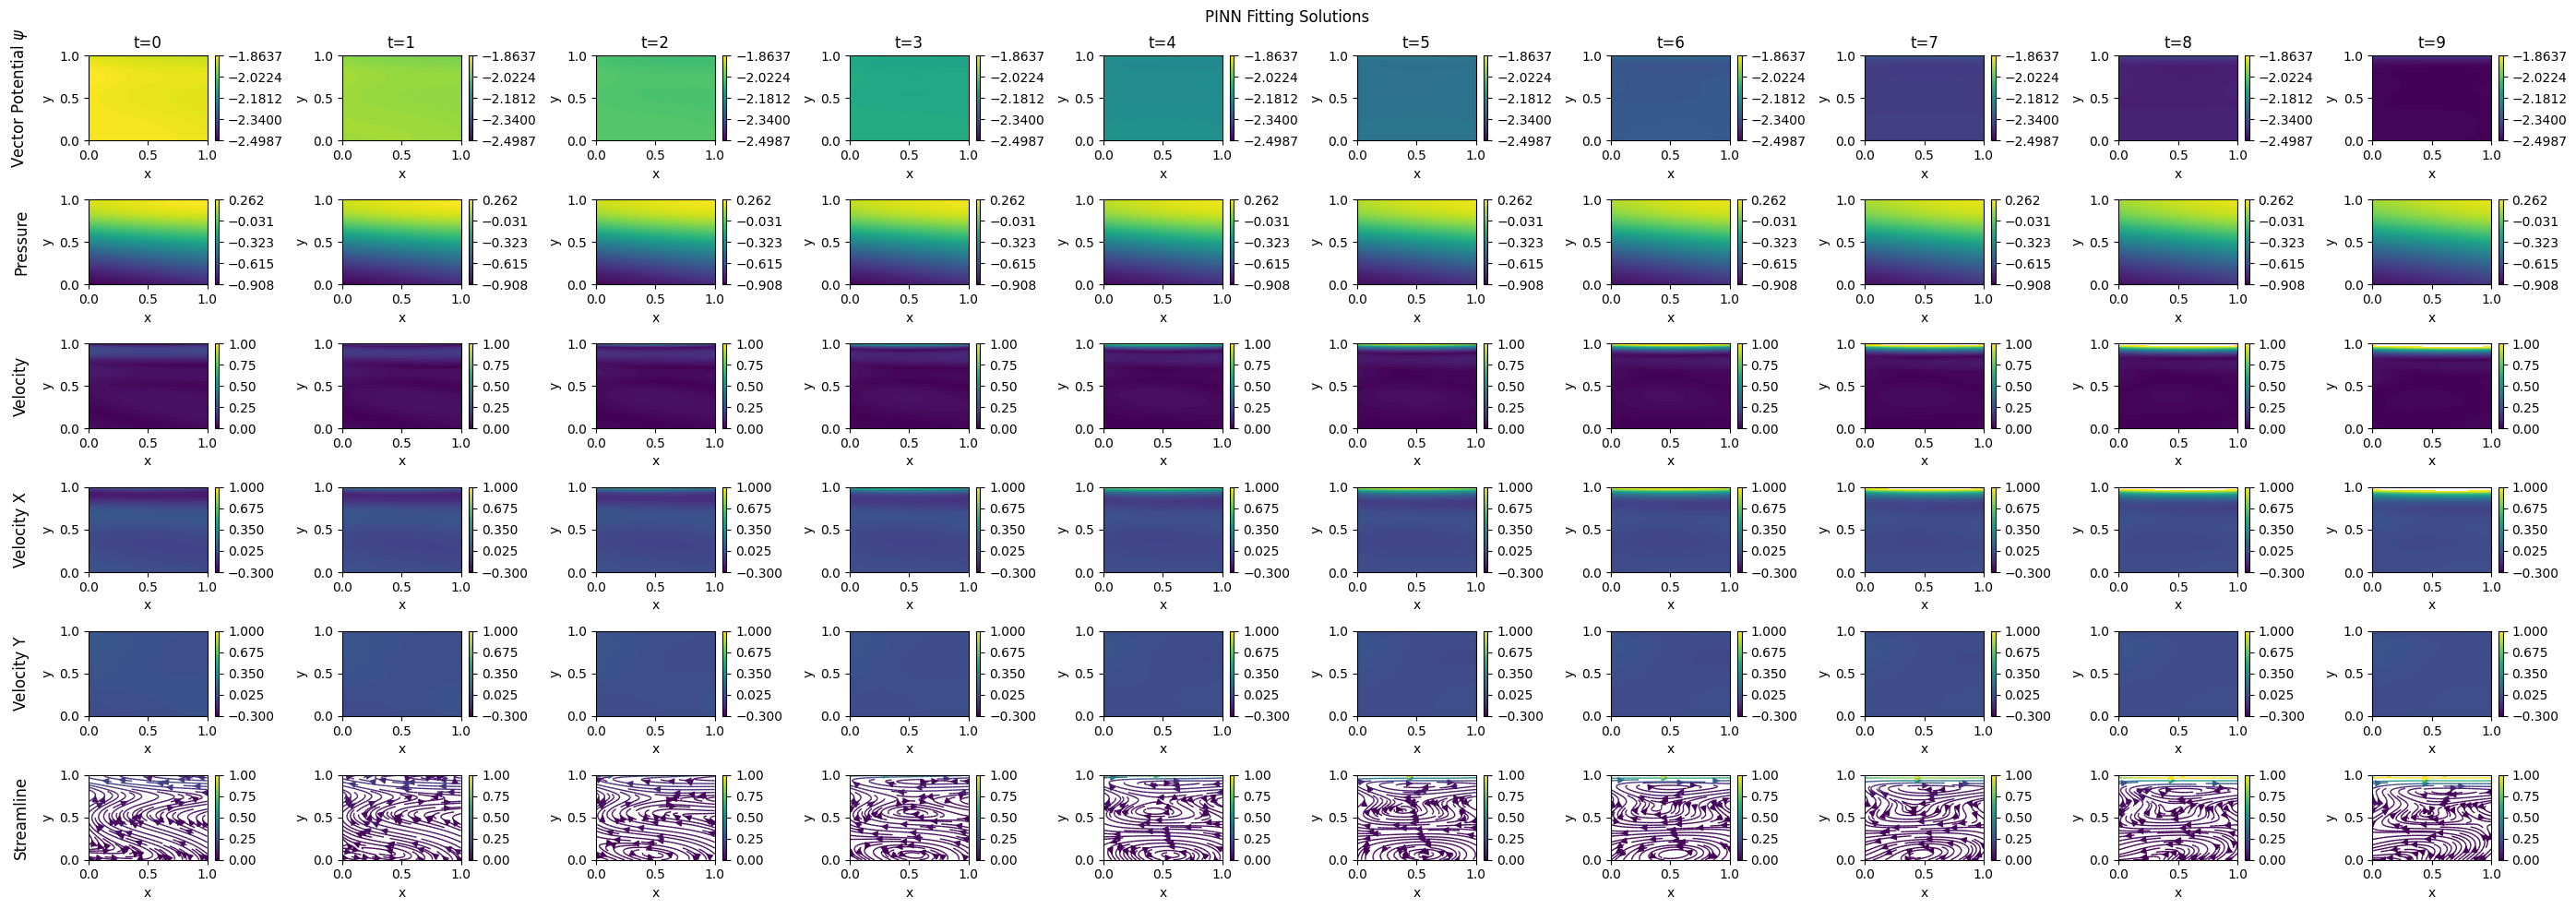

In [16]:
# Plotting
T_PLOTS = 10
fig, axs = plt.subplots(6,T_PLOTS, figsize=(28, 10))
axs = axs.ravel()

fig.suptitle("PINN Fitting Solutions")
axs[0].annotate("Vector Potential $\psi$", xy=(0, 0.5), xytext=(-axs[0].yaxis.labelpad - 5, 0),
                xycoords=axs[0].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center',rotation=90)
axs[1*T_PLOTS].annotate("Pressure", xy=(0, 0.5), xytext=(-axs[1*T_PLOTS].yaxis.labelpad - 5, 0),
                xycoords=axs[1*T_PLOTS].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center',rotation=90)
axs[2*T_PLOTS].annotate("Velocity", xy=(0, 0.5), xytext=(-axs[2*T_PLOTS].yaxis.labelpad - 5, 0),
                xycoords=axs[2*T_PLOTS].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center',rotation=90)
axs[3*T_PLOTS].annotate("Velocity X", xy=(0, 0.5), xytext=(-axs[3*T_PLOTS].yaxis.labelpad - 5, 0),
                xycoords=axs[3*T_PLOTS].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center',rotation=90)
axs[4*T_PLOTS].annotate("Velocity Y", xy=(0, 0.5), xytext=(-axs[4*T_PLOTS].yaxis.labelpad - 5, 0),
                xycoords=axs[4*T_PLOTS].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center',rotation=90)
axs[5*T_PLOTS].annotate("Streamline", xy=(0, 0.5), xytext=(-axs[5*T_PLOTS].yaxis.labelpad - 5, 0),
                xycoords=axs[5*T_PLOTS].yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center',rotation=90)


# Create normalization instance
norm_psi = mcolors.Normalize(vmin=psi_p_pinn[...,0].min(), vmax=psi_p_pinn[...,0].max())
norm_p = mcolors.Normalize(vmin=psi_p_pinn[...,1].min(), vmax=psi_p_pinn[...,1].max())

for t in range(T_PLOTS):
    # column header for time points
    if t//T_PLOTS == 0:
        axs[t].set_title('t={}'.format(t))

    # vector potential
    axs[t].set_xlabel("x")
    axs[t].set_ylabel("y")

    psi_t = psi_p_pinn[:,:,t,0]

    c1 = axs[t].contourf(X_[:,:,t], Y_[:,:,t], psi_t, levels=np.linspace(psi_p_pinn[...,0].min(),psi_p_pinn[...,0].max(),100), cmap='viridis')
    fig.colorbar(c1, ax=axs[t], location='right',ticks=np.linspace(psi_p_pinn[...,0].min(), psi_p_pinn[...,0].max(), 5))

    # pressure
    axs[1*T_PLOTS+t].set_xlabel("x")
    axs[1*T_PLOTS+t].set_ylabel("y")

    p_t = psi_p_pinn[:,:,t,1]
    c1 = axs[1*T_PLOTS+t].contourf(X_[:,:,t], Y_[:,:,t], p_t, levels=np.linspace(psi_p_pinn[...,1].min(),psi_p_pinn[...,1].max(),100))
    fig.colorbar(c1, ax=axs[1*T_PLOTS+t], location='right',ticks=np.linspace(psi_p_pinn[...,1].min(), psi_p_pinn[...,1].max(), 5))

    # velocity
    dpsidy, dpsidx =  np.gradient(psi_t,x_,y_)

    u = dpsidy
    v = -dpsidx
    c1 = axs[2*T_PLOTS+t].contourf(X_[:,:,t], Y_[:,:,t], np.hypot(u,v), levels=np.linspace(0,1,100), cmap='viridis')
    # q = axs[2*T_PLOTS+t].quiver(X_[:,:,t],Y_[:,:,t],u,v,np.hypot(u,v),pivot="tail")
    # q.set_clim(0,2)
    fig.colorbar(c1, ax=axs[2*T_PLOTS+t], location='right',ticks=np.linspace(0, 1, 5))

    axs[2*T_PLOTS+t].set_xlabel("x")
    axs[2*T_PLOTS+t].set_ylabel("y")

    c1 = axs[3*T_PLOTS+t].contourf(X_[:,:,t], Y_[:,:,t], u, levels=np.linspace(-0.3,1,100), cmap='viridis')

    fig.colorbar(c1, ax=axs[3*T_PLOTS+t], location='right',ticks=np.linspace(-0.3, 1, 5))

    axs[3*T_PLOTS+t].set_xlabel("x")
    axs[3*T_PLOTS+t].set_ylabel("y")

    c1 = axs[4*T_PLOTS+t].contourf(X_[:,:,t], Y_[:,:,t], v, levels=np.linspace(-0.3,1,100), cmap='viridis')

    fig.colorbar(c1, ax=axs[4*T_PLOTS+t], location='right',ticks=np.linspace(-0.3, 1, 5))

    axs[4*T_PLOTS+t].set_xlabel("x")
    axs[4*T_PLOTS+t].set_ylabel("y")

    # streamline
    norm = mcolors.Normalize(vmin=0, vmax=1)
    c1 = axs[5*T_PLOTS+t].streamplot(X_[:,:,t], Y_[:,:,t], u, v, color=np.hypot(u,v), linewidth=1, cmap='viridis', norm=norm)
    fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=axs[5*T_PLOTS+t], location='right',ticks=np.linspace(0, 1, 5))
    axs[5*T_PLOTS+t].set_xlabel("x")
    axs[5*T_PLOTS+t].set_ylabel("y")
    axs[5*T_PLOTS+t].set_xlim(0,1)
    axs[5*T_PLOTS+t].set_ylim(0,1)
    
plt.tight_layout()

## References
- [pinn_cavity](https://github.com/okada39/pinn_cavity/tree/master)
- [Amalinadhi, Cahya, et al. "On physics-informed deep learning for solving navier-stokes equations." AIAA SCITECH 2022 Forum. 2022.](https://arc.aiaa.org/doi/abs/10.2514/6.2022-1436)
- [Nvidia Modulus - Lid Driven Cavity](https://docs.nvidia.com/deeplearning/modulus/modulus-v2209/user_guide/basics/lid_driven_cavity_flow.html)
- [DL Young, CH Tsai, and CS Wu. A novel vector potential formulation of 3d navier–stokes equations with through-flow boundaries by a local meshless method. Journal of Computational Physics, 300:219–240, 2015.](https://www.sciencedirect.com/science/article/pii/S0021999115004854)
- [Wandel, Nils, Michael Weinmann, and Reinhard Klein. "LEARNING INCOMPRESSIBLE FLUID DYNAMICS FROM SCRATCH-TOWARDS FAST, DIFFERENTIABLE FLUID MODELS THAT GENERALIZE." arXiv preprint arXiv:2006.08762 (2020).](https://arxiv.org/abs/2006.08762)